In [30]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [31]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [32]:
import os
print(os.listdir('/content/'))

['.config', 'potato_di.zip', 'potato_di', 'sample_data']


In [33]:
import zipfile
with zipfile.ZipFile('/content/potato_di.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [34]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            'potato_di', # Updated path to the extracted folder
            shuffle=True,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE
        )

Found 2152 files belonging to 3 classes.


In [35]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [36]:
len(dataset)

68

In [37]:
68*32

2176

In [38]:
for image_batch,label_batch in dataset.take(1):

  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 2 0 0 1 0 0 1 0 1 1 1 0 1 1 2 0 1 1 0 1 2 1 1 2 1 0 1 1 2 0]


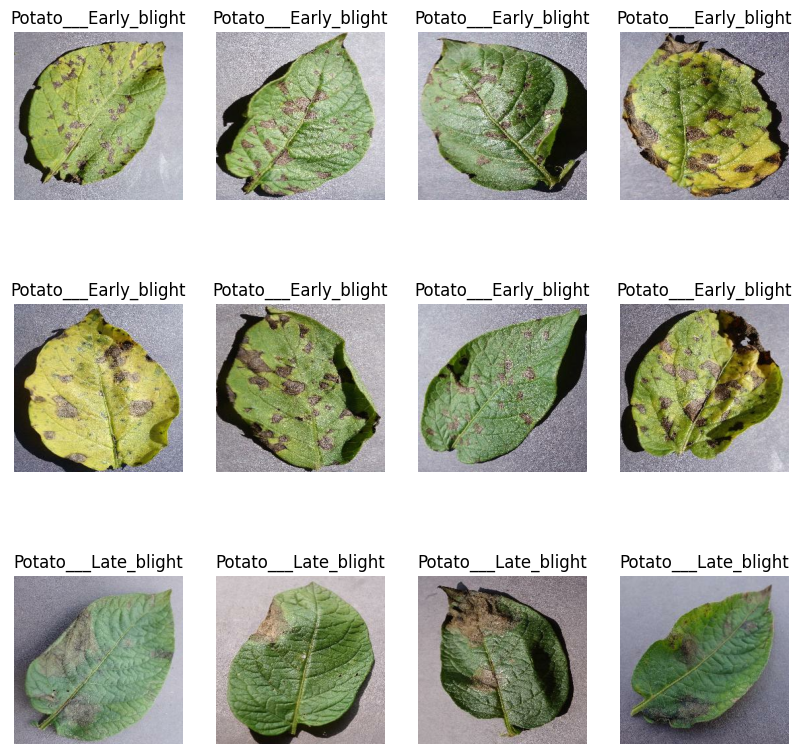

In [39]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')


In [40]:
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [41]:
train_dataset=dataset.take(54)
len(train_dataset)

54

In [42]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [43]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [44]:
test_ds.take(6)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [46]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [47]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split * ds_size)
  val_size=int(val_split * ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [48]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [49]:
len(train_ds)

54

In [50]:
len(val_ds)

6

In [51]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Use tf.keras.layers.Resizing
    tf.keras.layers.Rescaling(1. / 255)  # Use tf.keras.layers.Rescaling
])

In [53]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Changed to tf.keras.layers.RandomFlip
    tf.keras.layers.RandomRotation(0.2)  # Changed to tf.keras.layers.RandomRotation
])

In [54]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)


In [55]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.4721 - loss: 0.9837 - val_accuracy: 0.8333 - val_loss: 0.6441
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8435 - loss: 0.4580 - val_accuracy: 0.8438 - val_loss: 0.3752
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.8456 - loss: 0.3930 - val_accuracy: 0.9271 - val_loss: 0.1997
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.9426 - loss: 0.1588 - val_accuracy: 0.9115 - val_loss: 0.2278
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9421 - loss: 0.1535 - val_accuracy: 0.8177 - val_loss: 0.4434
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.9338 - loss: 0.1531 - val_accuracy: 0.9792 - val_loss: 0.0651
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.9129 - loss: 0.2486 - val_accuracy: 0.9219 - val_loss: 0.1655
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.9345 - loss: 0.1731 - val_accuracy: 0.9635 - v

In [58]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8743 - loss: 0.3886


In [59]:
scores

[0.4009827673435211, 0.86328125]

In [60]:
history

In [61]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [62]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [63]:
history.history['accuracy']

[0.5364583134651184,
 0.8466435074806213,
 0.8755787014961243,
 0.9461805820465088,
 0.9456018805503845,
 0.9484953880310059,
 0.9270833134651184,
 0.9403935074806213,
 0.9670138955116272,
 0.9722222089767456,
 0.9629629850387573,
 0.9432870149612427,
 0.9571759104728699,
 0.9658564925193787,
 0.9629629850387573]

In [ ]:
c

In [64]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

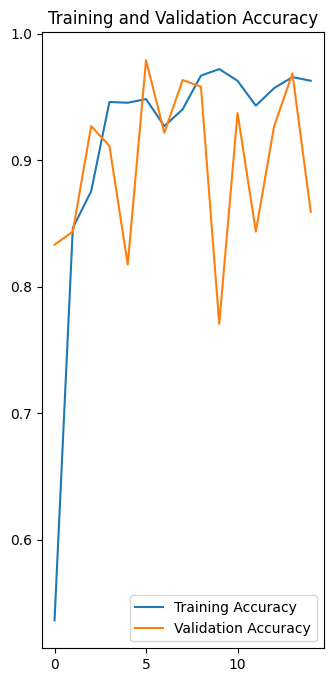

In [65]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(len(acc)),acc,label='Training Accuracy') # Changed range(EPOCHS) to range(len(acc))
plt.plot(range(len(val_acc)),val_acc,label='Validation Accuracy') # Changed range(EPOCHS) to range(len(val_acc))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Early_blight


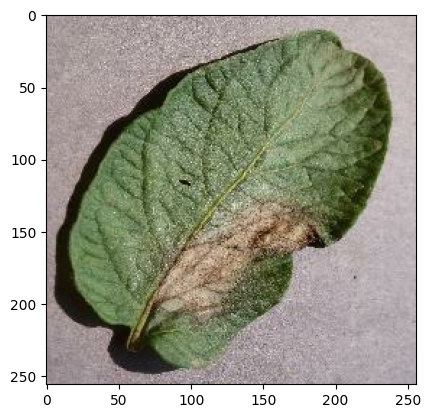

In [66]:
import numpy as np # Import the numpy library and assign it the alias 'np'

for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()
  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])
  batch_prediction=model.predict(images_batch)
  print('predicted label:',class_names[np.argmax(batch_prediction[0])]) # Now np is recognized

In [67]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


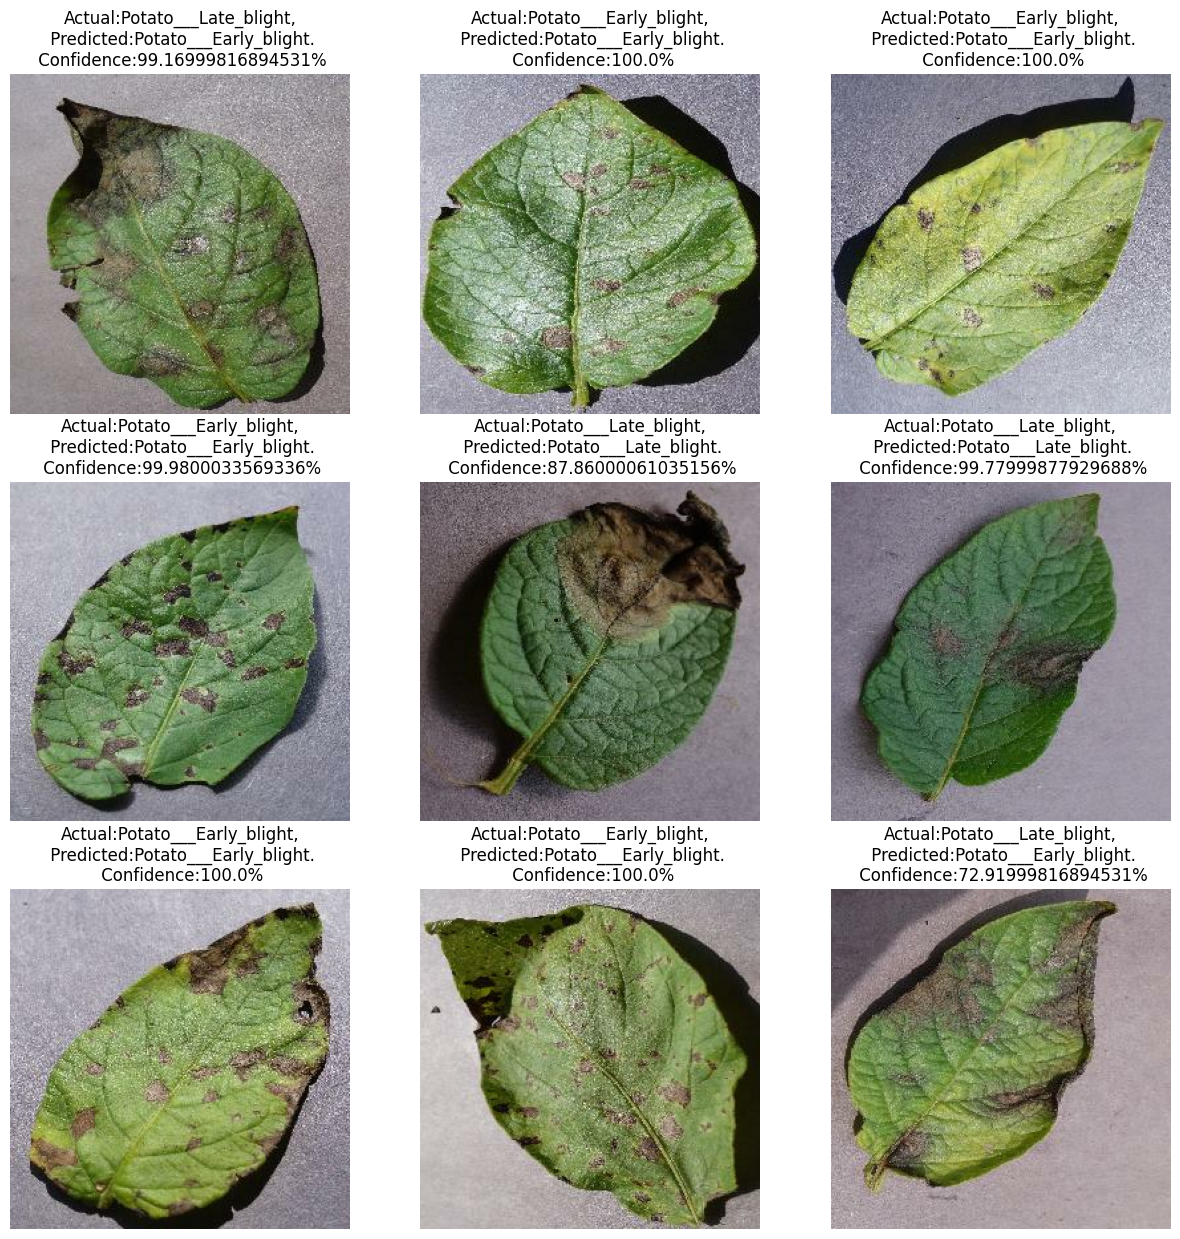

In [68]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    actual_label=class_names[labels[i].numpy()]
    predicted_label,confidence=predict(model,images)
    plt.title(f"Actual:{actual_label},\n Predicted:{predicted_label}.\n Confidence:{confidence}%")
    plt.axis('off')

In [69]:
model_version=1
model.save(f'/content/model{model_version}.keras') # Added '.keras' extension

In [ ]:
model.save("potato_disease_model.h5")


In [70]:
model.save("potato_disease_model.h5")
print("Model saved as potato_disease_model.h5")

Model saved as potato_disease_model.h5


In [71]:
model.save("potato_disease_model.keras")
print("Model saved as potato_disease_model.h5")

Model saved as potato_disease_model.h5


In [72]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.8 MB/s eta 0:00:00


In [73]:
import tensorflow as tf

# Load the trained model (upload the .h5 file to Colab first)
model = tf.keras.models.load_model("potato_disease_model.keras")

# Class names in the same order as training
class_names = ['Early Blight', 'Late Blight', 'Healthy']


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [74]:
import numpy as np
from PIL import Image

def predict_disease(image):
    image = image.resize((256, 256))
    img_array = np.array(image)

    if img_array.shape[-1] == 4:  # Remove alpha channel if present
        img_array = img_array[..., :3]

    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    return f"Prediction: {predicted_class}"


In [75]:
import gradio as gr

interface = gr.Interface(
    fn=predict_disease,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Potato Disease Classifier 🌿🥔",
    description="Upload an image of a potato leaf to predict whether it is Healthy, has Early Blight, or Late Blight."
)

interface.launch(share=True)  # share=True gives a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://58227ce1497463e4ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
